In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit, Probit, Poisson
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

print("=" * 70)
print("ECON 5140 - HOMEWORK 1")
print("Part A: Generalized Linear Models")
print("Part B: Time Series Decomposition")
print("=" * 70)

ECON 5140 - HOMEWORK 1
Part A: Generalized Linear Models
Part B: Time Series Decomposition


# # DATASET 1: CUSTOMER PURCHASE DATA (for GLM analysis)

In [4]:
print("\n" + "=" * 70)
print("DATASET 1: Customer Purchase Behavior")
print("=" * 70)

n_customers = 1000

# Generate customer features
age = np.random.normal(35, 10, n_customers)
income = np.random.normal(50, 15, n_customers)  # in thousands
time_on_site = np.random.gamma(2, 3, n_customers)  # in minutes

# True relationship (latent variable)
z = -3 + 0.05*age + 0.04*income + 0.15*time_on_site + np.random.normal(0, 1, n_customers)

# Generate binary outcome (Purchase: 1=Yes, 0=No)
purchase = (z > 0).astype(int)

# Create DataFrame
df_customers = pd.DataFrame({
    'Age': age,
    'Income': income,
    'TimeOnSite': time_on_site,
    'Purchase': purchase
})

print(f"Number of customers: {len(df_customers)}")
print(f"Purchase rate: {df_customers['Purchase'].mean():.2%}")
print(f"\nFirst 5 rows:")
print(df_customers.head())



DATASET 1: Customer Purchase Behavior
Number of customers: 1000
Purchase rate: 90.00%

First 5 rows:
         Age     Income  TimeOnSite  Purchase
0  39.967142  70.990332    2.814421         1
1  33.617357  63.869505    4.460907         1
2  41.476885  50.894456    0.667441         1
3  50.230299  40.295948    5.872412         1
4  32.658466  60.473350    8.012511         1


# DATASET 2: E-COMMERCE SALES TIME SERIES

In [30]:
print("\n" + "=" * 70)
print("DATASET 2: E-commerce Daily Sales")
print("=" * 70)

# Create 2 years of daily data
dates = pd.date_range('2024-01-01', '2025-12-31', freq='D')
n_days = len(dates)
t = np.arange(n_days)

# Components
trend = 1000 + 2*t + 0.01*t**2
yearly_seasonal = 200 * np.sin(2*np.pi*t/365) + 150 * np.cos(2*np.pi*t/365)
weekly_seasonal = 100 * np.sin(2*np.pi*t/7)

# Special events
special_events = np.zeros(n_days)
for year in [2024, 2025]:
    # Black Friday
    bf_date = pd.Timestamp(f'{year}-11-24')
    bf_idx = (dates == bf_date)
    special_events[bf_idx] = 800
    
    # Christmas
    xmas_idx = (dates >= f'{year}-12-20') & (dates <= f'{year}-12-25')
    special_events[xmas_idx] = 400

# Random noise
noise = np.random.normal(0, 50, n_days)

# Combine components
sales = trend + yearly_seasonal + weekly_seasonal + special_events + noise
sales = np.maximum(sales, 0)

# Create DataFrame
df_sales = pd.DataFrame({
    'Date': dates,
    'Sales': sales,
    'DayOfWeek': dates.dayofweek,
    'Month': dates.month,
    'IsWeekend': dates.dayofweek >= 5
})
df_sales.set_index('Date', inplace=True)

print(f"Date range: {df_sales.index[0].date()} to {df_sales.index[-1].date()}")
print(f"Number of days: {len(df_sales)}")
print(f"\nSales Statistics:")
print(df_sales['Sales'].describe())
print(df_sales)


DATASET 2: E-commerce Daily Sales
Date range: 2024-01-01 to 2025-12-31
Number of days: 731

Sales Statistics:
count     731.000000
mean     3515.098101
std      1973.038173
min      1061.388824
25%      1587.211754
50%      3304.552751
75%      4954.843016
max      8308.867019
Name: Sales, dtype: float64
                  Sales  DayOfWeek  Month  IsWeekend
Date                                                
2024-01-01  1172.025980          0      1      False
2024-01-02  1187.665139          1      1      False
2024-01-03  1290.694858          2      1      False
2024-01-04  1128.208033          3      1      False
2024-01-05  1061.388824          4      1      False
...                 ...        ...    ...        ...
2025-12-27  7880.747266          5     12       True
2025-12-28  7762.213900          6     12       True
2025-12-29  7894.978153          0     12      False
2025-12-30  7974.323010          1     12      False
2025-12-31  7984.511094          2     12      False

[73

# PART A: GENERALIZED LINEAR MODELS

In [6]:
print("\n" + "=" * 70)
print("PART A: GENERALIZED LINEAR MODELS")
print("=" * 70)



PART A: GENERALIZED LINEAR MODELS


# A1: Exploratory Data Analysis (GLM)


----------------------------------------------------------------------
A1: Exploratory Data Analysis
----------------------------------------------------------------------

Mean values by Purchase Status:

Age:
  Non-purchasers (0): 28.67 years
  Purchasers (1):     35.92 years

Income:
  Non-purchasers (0): $40.15k
  Purchasers (1):     $52.27k

Time On Site:
  Non-purchasers (0): 3.93 minutes
  Purchasers (1):     6.34 minutes

Correlation Matrix:
                 Age    Income  TimeOnSite  Purchase
Age         1.000000 -0.040400    0.004522  0.222049
Income     -0.040400  1.000000   -0.045958  0.243186
TimeOnSite  0.004522 -0.045958    1.000000  0.164197
Purchase    0.222049  0.243186    0.164197  1.000000


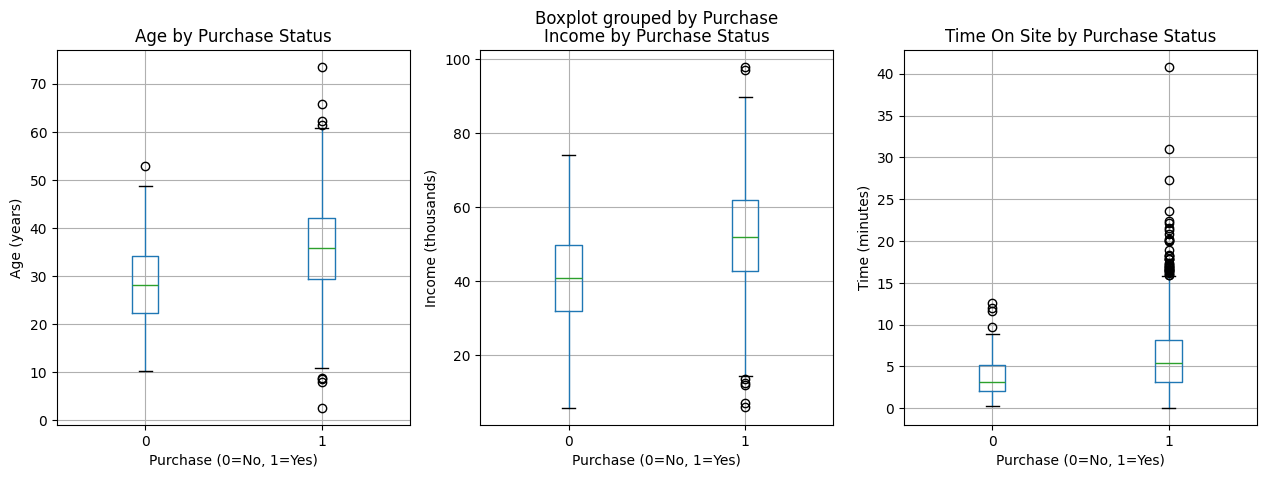

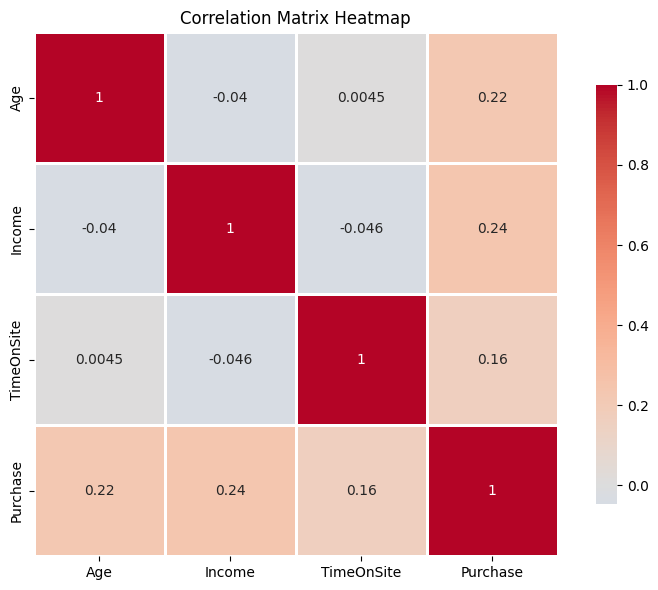

In [ ]:
print("\n" + "-" * 70)
print("A1: Exploratory Data Analysis")
print("-" * 70)

# YOUR CODE:
# 1. Create box plots comparing Age, Income, and TimeOnSite
#    between purchasers and non-purchasers
#    - Use 3 subplots (1 row, 3 columns)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Box plot for Age
df_customers.boxplot(column='Age', by='Purchase', ax=axes[0])
axes[0].set_title('Age by Purchase Status')
axes[0].set_xlabel('Purchase (0=No, 1=Yes)')
axes[0].set_ylabel('Age (years)')

# Box plot for Income
df_customers.boxplot(column='Income', by='Purchase', ax=axes[1])
axes[1].set_title('Income by Purchase Status')
axes[1].set_xlabel('Purchase (0=No, 1=Yes)')
axes[1].set_ylabel('Income (thousands)')

# Box plot for TimeOnSite
df_customers.boxplot(column='TimeOnSite', by='Purchase', ax=axes[2])
axes[2].set_title('Time On Site by Purchase Status')
axes[2].set_xlabel('Purchase (0=No, 1=Yes)')
axes[2].set_ylabel('Time (minutes)')



# 2. Calculate and print mean values for each group:
#    - Mean Age: Purchasers vs Non-purchasers
#    - Mean Income: Purchasers vs Non-purchasers
#    - Mean TimeOnSite: Purchasers vs Non-purchasers

print("\nMean values by Purchase Status:")
print("=" * 50)

# Group by Purchase status
grouped = df_customers.groupby('Purchase')

# Calculate means
mean_age = grouped['Age'].mean()
mean_income = grouped['Income'].mean()
mean_time = grouped['TimeOnSite'].mean()

print(f"\nAge:")
print(f"  Non-purchasers (0): {mean_age[0]:.2f} years")
print(f"  Purchasers (1):     {mean_age[1]:.2f} years")

print(f"\nIncome:")
print(f"  Non-purchasers (0): ${mean_income[0]:.2f}k")
print(f"  Purchasers (1):     ${mean_income[1]:.2f}k")

print(f"\nTime On Site:")
print(f"  Non-purchasers (0): {mean_time[0]:.2f} minutes")
print(f"  Purchasers (1):     {mean_time[1]:.2f} minutes")


# 3. Create a correlation matrix heatmap for the features

print("\n" + "=" * 50)
print("Correlation Matrix:")
print("=" * 50)

# Calculate correlation matrix
correlation_matrix = df_customers[['Age', 'Income', 'TimeOnSite', 'Purchase']].corr()

# Display correlation matrix
print(correlation_matrix)

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()


# A2: Linear Probability Model (LPM)


----------------------------------------------------------------------
A2: Linear Probability Model
----------------------------------------------------------------------

Linear Probability Model Summary:
                            OLS Regression Results                            
Dep. Variable:               Purchase   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     55.67
Date:                Thu, 29 Jan 2026   Prob (F-statistic):           2.86e-33
Time:                        15:11:49   Log-Likelihood:                -137.46
No. Observations:                1000   AIC:                             282.9
Df Residuals:                     996   BIC:                             302.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
   

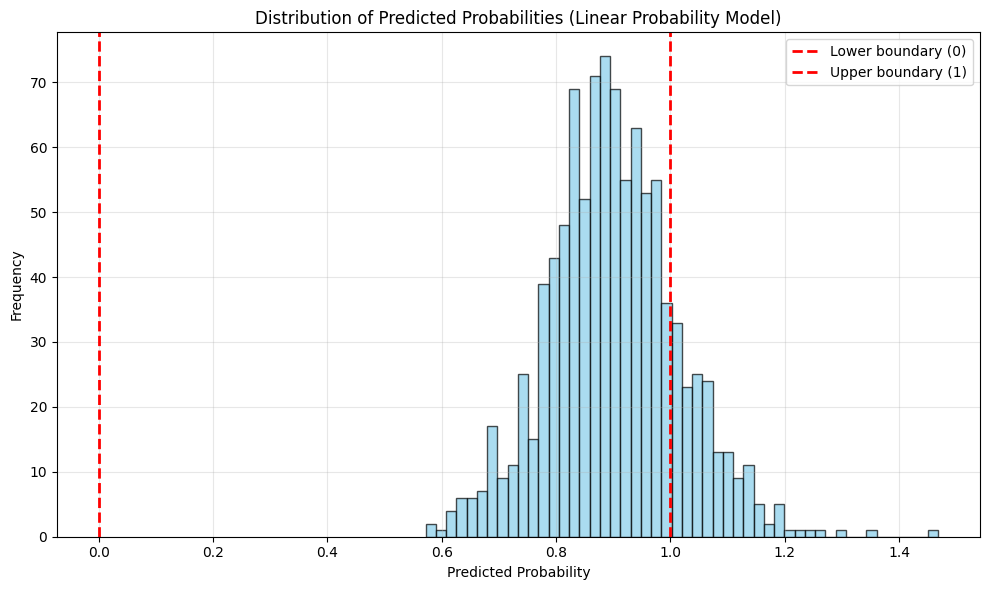

In [15]:
print("\n" + "-" * 70)
print("A2: Linear Probability Model")
print("-" * 70)

# YOUR CODE:
# 1. Fit OLS model: Purchase ~ Age + Income + TimeOnSite
#    - Add constant using sm.add_constant()
#    - Use sm.OLS()
X = df_customers[['Age', 'Income', 'TimeOnSite']]# Prepare independent and dependent variables
y = df_customers['Purchase']

X_with_const = sm.add_constant(X)# Add constant term (intercept)
lpm_model = sm.OLS(y, X_with_const).fit() # Fit OLS model



# 2. Print regression summary
print("\nLinear Probability Model Summary:")
print("=" * 70)
print(lpm_model.summary())


# 3. Calculate predicted probabilities
#    - Count how many predictions are outside [0, 1]
#    - Print the percentage of invalid predictions
predicted_prob = lpm_model.predict(X_with_const)# Get predicted probabilities
invalid_predictions = ((predicted_prob < 0) | (predicted_prob > 1)).sum()# Count invalid predictions (less than 0 or greater than 1)
total_predictions = len(predicted_prob)
percentage_invalid = (invalid_predictions / total_predictions) * 100
print("\n" + "=" * 70)
print("Predicted Probabilities Analysis:")
print("=" * 70)
print(f"Total predictions: {total_predictions}")
print(f"Predictions < 0: {(predicted_prob < 0).sum()}")
print(f"Predictions > 1: {(predicted_prob > 1).sum()}")
print(f"Invalid predictions (outside [0,1]): {invalid_predictions}")
print(f"Percentage of invalid predictions: {percentage_invalid:.2f}%")
print(f"\nMin predicted probability: {predicted_prob.min():.4f}")
print(f"Max predicted probability: {predicted_prob.max():.4f}")

# 4. Create histogram of predicted probabilities
#    - Mark the [0, 1] boundaries with vertical lines
plt.figure(figsize=(10, 6))
plt.hist(predicted_prob, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Lower boundary (0)')
plt.axvline(x=1, color='red', linestyle='--', linewidth=2, label='Upper boundary (1)')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities (Linear Probability Model)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# A3: Logistic Regression


----------------------------------------------------------------------
A3: Logistic Regression
----------------------------------------------------------------------
Optimization terminated successfully.
         Current function value: 0.238157
         Iterations 8

Logistic Regression Summary:
                           Logit Regression Results                           
Dep. Variable:               Purchase   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      996
Method:                           MLE   Df Model:                            3
Date:                Thu, 29 Jan 2026   Pseudo R-squ.:                  0.2674
Time:                        15:18:44   Log-Likelihood:                -238.16
converged:                       True   LL-Null:                       -325.08
Covariance Type:            nonrobust   LLR p-value:                 1.874e-37
                 coef    std err          z      P>|z|      [0.025   

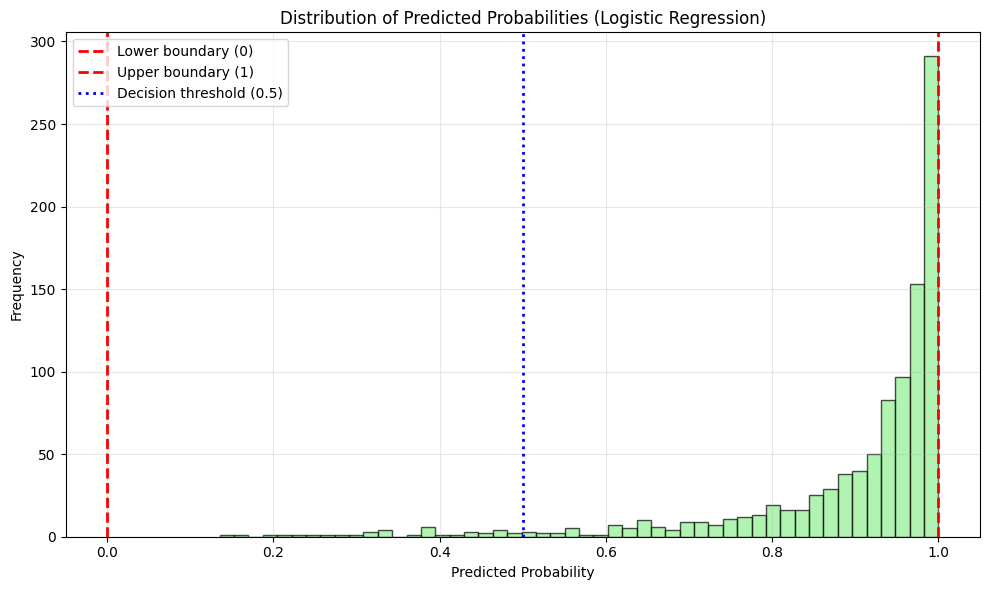

In [21]:
print("\n" + "-" * 70)
print("A3: Logistic Regression")
print("-" * 70)

# YOUR CODE:
# 1. Fit logistic regression: sm.Logit()
X = df_customers[['Age', 'Income', 'TimeOnSite']]
y = df_customers['Purchase']
X_with_const = sm.add_constant(X)

logit_model = sm.Logit(y, X_with_const).fit()


# 2. Print summary and extract:
#    - Coefficients
#    - Odds ratios: np.exp(coefficients)
#    - p-values
print("\nLogistic Regression Summary:")
print("=" * 70)
print(logit_model.summary())

print("\n" + "=" * 70)
print("Coefficients, Odds Ratios, and P-values:")
print("=" * 70)

coefficients = logit_model.params # Extract coefficients
odds_ratios = np.exp(coefficients) # Calculate odds ratios
p_values = logit_model.pvalues # Extract p-values
summary_df = pd.DataFrame({'Coefficient': coefficients,'Odds Ratio': odds_ratios,'P-value': p_values})

print(summary_df)



# 3. Interpret each coefficient:
#    - Age: Effect on log-odds
#    - Income: Effect on log-odds
#    - TimeOnSite: Effect on log-odds
print("\n" + "=" * 70)
print("Interpretation of Coefficients:")
print("=" * 70)

print(f"\nAge:")
print(f"  Coefficient: {coefficients['Age']:.4f}")
print(f"  Odds Ratio: {odds_ratios['Age']:.4f}")
print(f"  Interpretation: For each 1-year increase in age, the odds of purchase")
print(f"                  multiply by {odds_ratios['Age']:.4f} (or change by {(odds_ratios['Age']-1)*100:.2f}%)")

print(f"\nIncome:")
print(f"  Coefficient: {coefficients['Income']:.4f}")
print(f"  Odds Ratio: {odds_ratios['Income']:.4f}")
print(f"  Interpretation: For each $1k increase in income, the odds of purchase")
print(f"                  multiply by {odds_ratios['Income']:.4f} (or change by {(odds_ratios['Income']-1)*100:.2f}%)")

print(f"\nTimeOnSite:")
print(f"  Coefficient: {coefficients['TimeOnSite']:.4f}")
print(f"  Odds Ratio: {odds_ratios['TimeOnSite']:.4f}")
print(f"  Interpretation: For each 1-minute increase in time on site, the odds of purchase")
print(f"                  multiply by {odds_ratios['TimeOnSite']:.4f} (or change by {(odds_ratios['TimeOnSite']-1)*100:.2f}%)")


# 4. Calculate predicted probabilities
#    - Verify all are in [0, 1]
#    - Create histogram

predicted_prob_logit = logit_model.predict(X_with_const)

# Verify all predictions are in [0, 1]
print("\n" + "=" * 70)
print("Predicted Probabilities Analysis:")
print("=" * 70)
print(f"Total predictions: {len(predicted_prob_logit)}")
print(f"Predictions < 0: {(predicted_prob_logit < 0).sum()}")
print(f"Predictions > 1: {(predicted_prob_logit > 1).sum()}")
print(f"All predictions in [0, 1]: {((predicted_prob_logit >= 0) & (predicted_prob_logit <= 1)).all()}")
print(f"\nMin predicted probability: {predicted_prob_logit.min():.4f}")
print(f"Max predicted probability: {predicted_prob_logit.max():.4f}")

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(predicted_prob_logit, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Lower boundary (0)')
plt.axvline(x=1, color='red', linestyle='--', linewidth=2, label='Upper boundary (1)')
plt.axvline(x=0.5, color='blue', linestyle=':', linewidth=2, label='Decision threshold (0.5)')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities (Logistic Regression)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()


print("\n" + "=" * 70)
print("Comparison: Linear Probability Model vs Logistic Regression")
print("=" * 70)
print(f"LPM - Invalid predictions: {percentage_invalid:.2f}%")
print(f"Logistic - Invalid predictions: 0.00%")
print("\nLogistic regression guarantees all predictions are in [0, 1]!")

# A4: Prediction for New Customers

In [25]:
print("\n" + "-" * 70)
print("A4: Predictions for New Customers")
print("-" * 70)

# New customers
new_customers = pd.DataFrame({
    'Age': [25, 35, 45, 55],
    'Income': [30, 50, 70, 90],
    'TimeOnSite': [2, 5, 8, 10]
})

# YOUR CODE:
# 1. Use your logistic model to predict purchase probability
#    for each new customer
new_customers_with_const = sm.add_constant(new_customers) # Add constant term to new customers data
predicted_prob_new = logit_model.predict(new_customers_with_const) # Predict purchase probabilities using the logistic model
new_customers['Predicted_Probability'] = predicted_prob_new # Add predictions to the dataframe

# 2. Create a nice formatted table showing:
#    - Customer features
#    - Predicted probability
#    - Classification (Purchase = 1 if p > 0.5)
new_customers['Classification'] = (predicted_prob_new > 0.5).astype(int) # Add classification column
new_customers['Decision'] = new_customers['Classification'].map({
    0: 'No Purchase',
    1: 'Purchase'
})
print("\nPredictions for New Customers:")
print("=" * 70)
print(new_customers.to_string(index=False))


# 3. Which customer is most likely to purchase? Why?
print("\n" + "=" * 70)
print("Analysis: Most Likely to Purchase")
print("=" * 70)

max_prob_idx = predicted_prob_new.argmax()
max_prob = predicted_prob_new.max()
print(f"\nCustomer {max_prob_idx + 1} is most likely to purchase!")
print(f"Purchase probability: {max_prob:.4f} ({max_prob*100:.2f}%)")





----------------------------------------------------------------------
A4: Predictions for New Customers
----------------------------------------------------------------------

Predictions for New Customers:
 Age  Income  TimeOnSite  Predicted_Probability  Classification    Decision
  25      30           2               0.371500               0 No Purchase
  35      50           5               0.942887               1    Purchase
  45      70           8               0.997836               1    Purchase
  55      90          10               0.999898               1    Purchase

Analysis: Most Likely to Purchase

Customer 4 is most likely to purchase!
Purchase probability: 0.9999 (99.99%)


# PART B: TIME SERIES ANALYSIS

In [26]:
print("\n" + "=" * 70)
print("PART B: TIME SERIES ANALYSIS")
print("=" * 70)



PART B: TIME SERIES ANALYSIS


# B1: Time Series Visualization


----------------------------------------------------------------------
B1: Time Series Visualization
----------------------------------------------------------------------

Mean Sales by Day of Week:
Mon: $3522.60
Tue: $3596.69
Wed: $3621.39
Thu: $3534.35
Fri: $3462.56
Sat (Weekend): $3421.21
Sun (Weekend): $3445.00

Highest average: Wed ($3621.39)
Lowest average: Sat ($3421.21)

Mean Sales by Month:
Jan: $2327.50
Feb: $2540.58
Mar: $2743.56
Apr: $2898.69
May: $3022.61
Jun: $3164.05
Jul: $3346.56
Aug: $3580.81
Sep: $3924.31
Oct: $4344.18
Nov: $4838.29
Dec: $5396.12

Highest average: Dec ($5396.12)
Lowest average: Jan ($2327.50)

Observed Patterns:

1. OVERALL TREND:
   - Sales show an upward trend over the 2-year period. This indicates business growth over time

2. YEARLY SEASONAL PATTERN:
   - Peak sales occur around Mar, Oct, Nov and Dec (likely due to holiday shopping, Black Friday and Christmas periods show significant sales increase)
   - Lower sales in Jan, Apr and May
    - Str

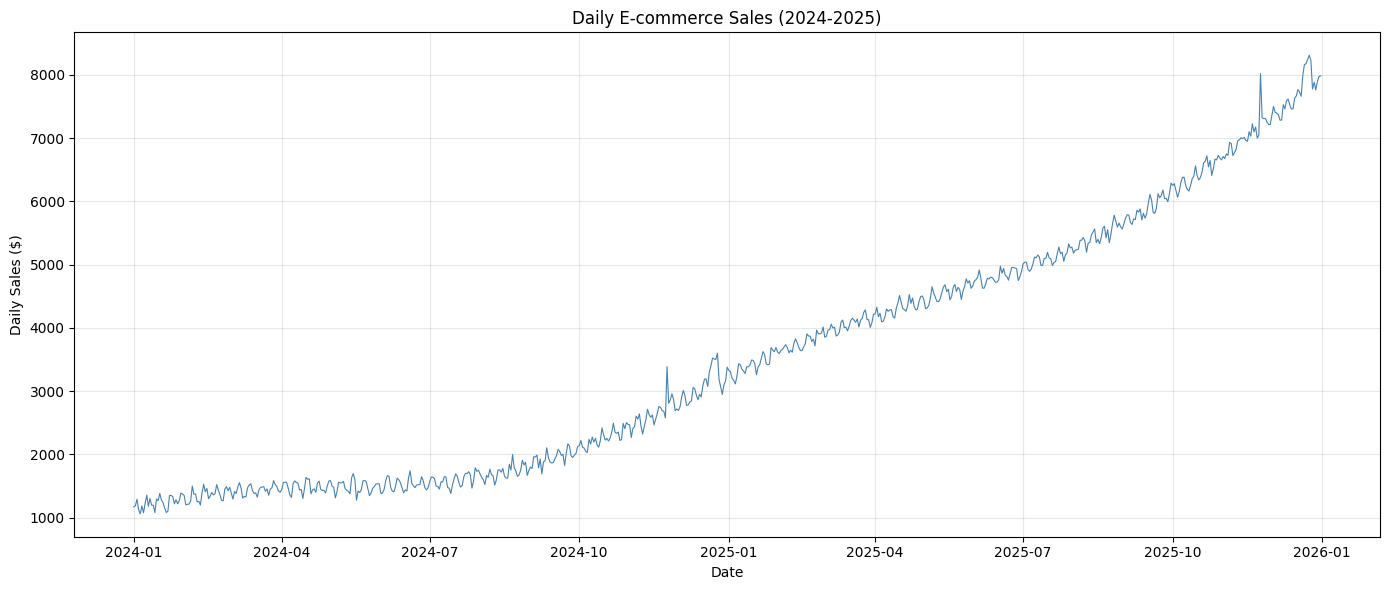

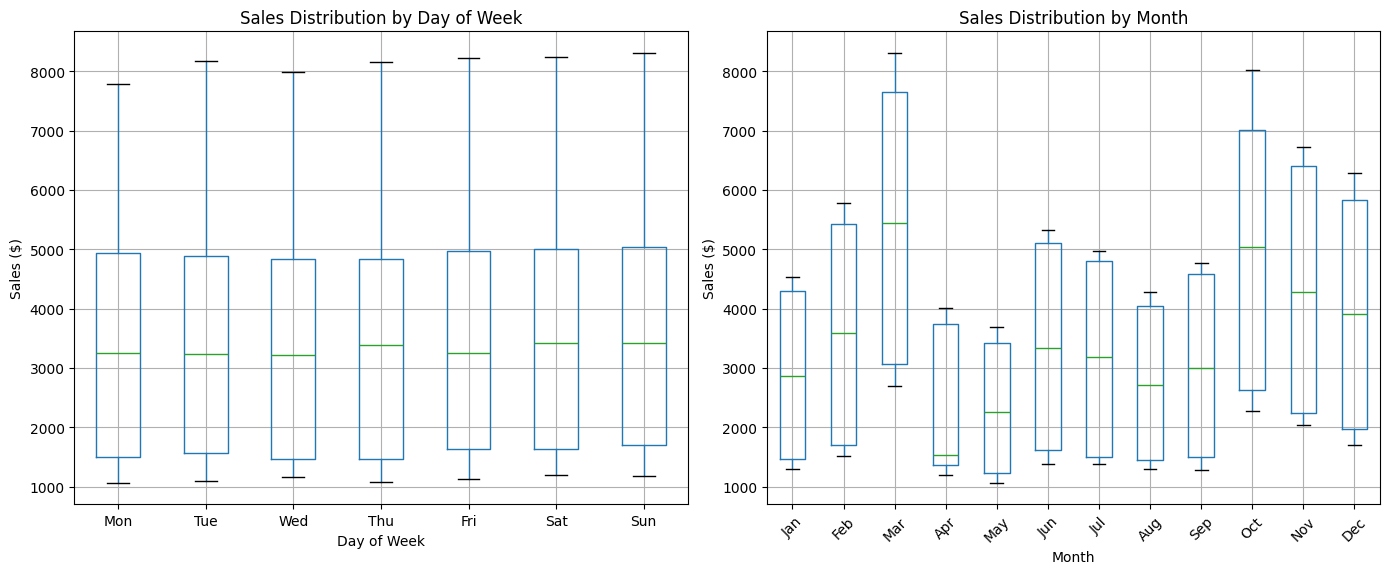

In [33]:
print("\n" + "-" * 70)
print("B1: Time Series Visualization")
print("-" * 70)

# YOUR CODE:
# 1. Create time series plot of daily sales
#    - Full 2-year series
#    - Label axes appropriately

plt.figure(figsize=(14, 6))
plt.plot(df_sales.index, df_sales['Sales'], linewidth=0.8, color='steelblue')
plt.xlabel('Date')
plt.ylabel('Daily Sales ($)')
plt.title('Daily E-commerce Sales (2024-2025)')
plt.grid(True, alpha=0.3)
plt.tight_layout()


# 2. Create seasonal subseries plots:
#    - Box plot: Sales by day of week
#    - Box plot: Sales by month

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']# Box plot: Sales by day of week
df_sales['DayName'] = df_sales['DayOfWeek'].map(dict(enumerate(day_names)))

df_sales.boxplot(column='Sales', by='DayName', ax=axes[0],
                 positions=range(7))
axes[0].set_title('Sales Distribution by Day of Week')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Sales ($)')
axes[0].set_xticklabels(day_names)

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_sales['MonthName'] = df_sales['Month'].map(dict(enumerate(month_names, 1)))

df_sales.boxplot(column='Sales', by='MonthName', ax=axes[1],
                 positions=range(1, 13))
axes[1].set_title('Sales Distribution by Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Sales ($)')
axes[1].set_xticklabels(month_names, rotation=45)

# Remove automatic suptitle
plt.suptitle('')
plt.tight_layout()

# 3. Calculate and print:
#    - Mean sales by day of week
#    - Mean sales by month
print("\n" + "=" * 70)
print("Mean Sales by Day of Week:")
print("=" * 70)

mean_sales_by_day = df_sales.groupby('DayOfWeek')['Sales'].mean()
for day_idx, mean_sales in mean_sales_by_day.items():
    day_name = day_names[day_idx]
    is_weekend = " (Weekend)" if day_idx >= 5 else ""
    print(f"{day_name}{is_weekend}: ${mean_sales:.2f}")

print(f"\nHighest average: {day_names[mean_sales_by_day.idxmax()]} (${mean_sales_by_day.max():.2f})")
print(f"Lowest average: {day_names[mean_sales_by_day.idxmin()]} (${mean_sales_by_day.min():.2f})")


print("\n" + "=" * 70)
print("Mean Sales by Month:")
print("=" * 70)

mean_sales_by_month = df_sales.groupby('Month')['Sales'].mean()
for month_idx, mean_sales in mean_sales_by_month.items():
    month_name = month_names[month_idx - 1]
    print(f"{month_name:>3}: ${mean_sales:.2f}")

print(f"\nHighest average: {month_names[mean_sales_by_month.idxmax() - 1]} (${mean_sales_by_month.max():.2f})")
print(f"Lowest average: {month_names[mean_sales_by_month.idxmin() - 1]} (${mean_sales_by_month.min():.2f})")

# 4. What patterns do you observe?

print("\n" + "=" * 70)
print("Observed Patterns:")
print("=" * 70)

print("\n1. OVERALL TREND:")
print("   - Sales show an upward trend over the 2-year period. This indicates business growth over time")

print("\n2. YEARLY SEASONAL PATTERN:")
print(f"   - Peak sales occur around Mar, Oct, Nov and Dec (likely due to holiday shopping, Black Friday and Christmas periods show significant sales increase)")
print(f"   - Lower sales in Jan, Apr and May")
print("    - Strong seasonal fluctuation throughout the year")

print("\n3. WEEKLY SEASONAL PATTERN:")
# Compare weekday vs weekend
weekday_sales = mean_sales_by_day[:5].mean()
weekend_sales = mean_sales_by_day[5:].mean()
diff_pct = ((weekend_sales - weekday_sales) / weekday_sales) * 100
print(f"   - Average weekday sales: ${weekday_sales:.2f}")
print(f"   - Average weekend sales: ${weekend_sales:.2f}")
if weekend_sales > weekday_sales:
    print(f"   - Weekend sales are {diff_pct:.1f}% higher than weekdays")
else:
    print(f"   - Weekday sales are {abs(diff_pct):.1f}% higher than weekends")



# B2: Stationarity Assessment


----------------------------------------------------------------------
B2: Stationarity Check
----------------------------------------------------------------------
The series is NON-STATIONARY
  - Mean changes significantly over time (upward trend)
  - Variance changes over time (heteroscedasticity)

Comparison: First 6 Months vs Last 6 Months

First 6 Months:
  Mean:              $1419.68
  Standard Deviation: $135.04

Last 6 Months:
  Mean:              $6295.85
  Standard Deviation: $921.57

Changes:
  Mean difference:    $+4876.17 (+343.47%)
  Std difference:     $+786.53 (+582.44%)


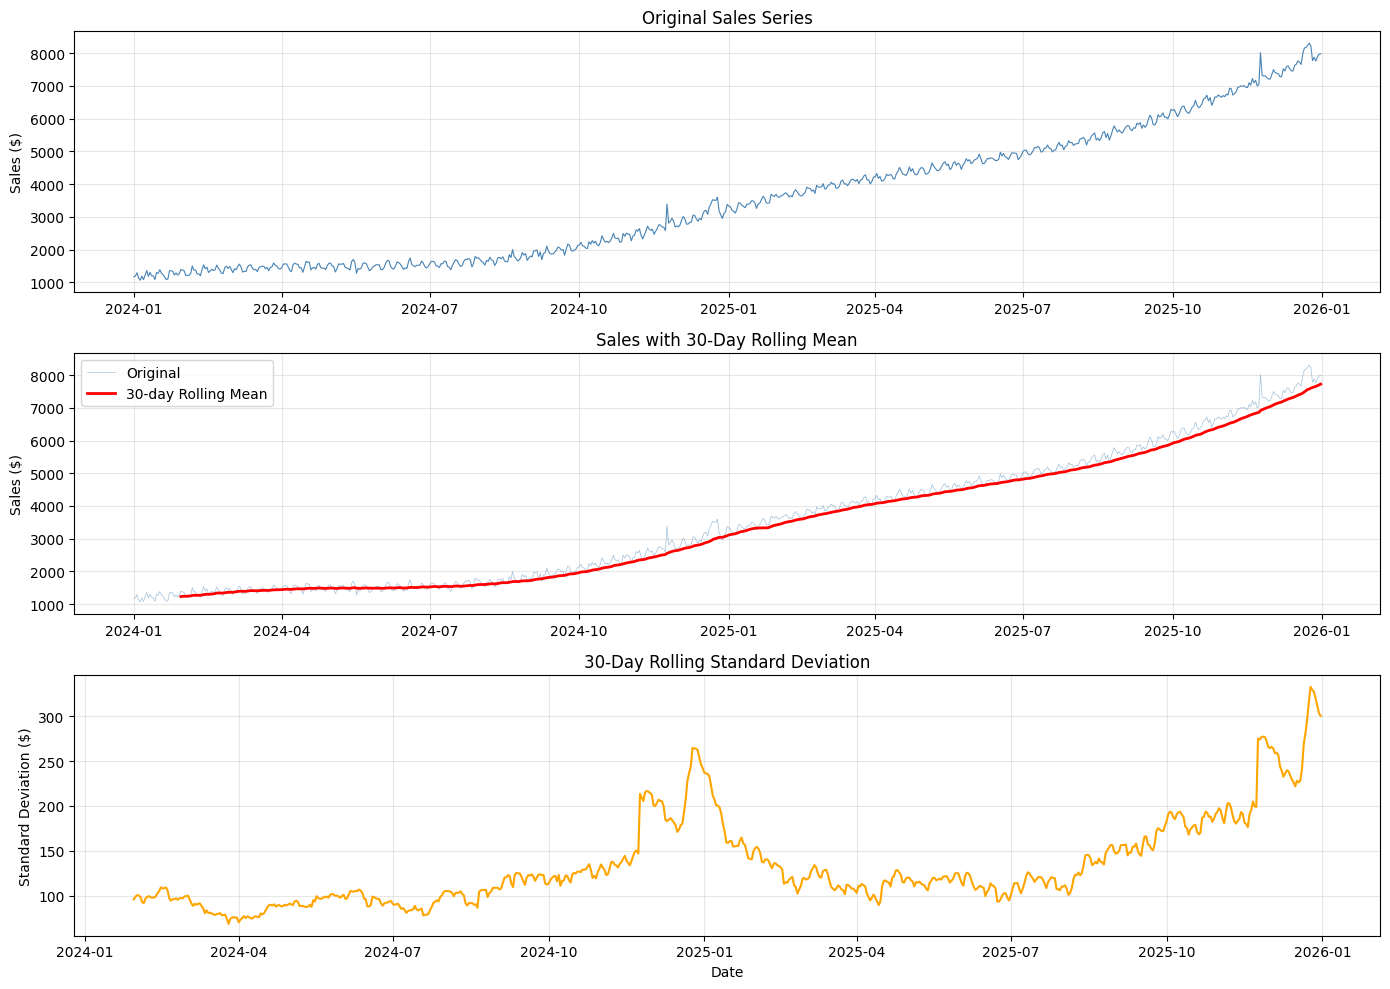

In [37]:
print("\n" + "-" * 70)
print("B2: Stationarity Check")
print("-" * 70)

# YOUR CODE:
# 1. Create a plot with 3 subplots:
#    - Original series
#    - Rolling mean (30-day window)
#    - Rolling std (30-day window)

rolling_mean = df_sales['Sales'].rolling(window=30).mean()
rolling_std = df_sales['Sales'].rolling(window=30).std()

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Original series
axes[0].plot(df_sales.index, df_sales['Sales'], color='steelblue', linewidth=0.8)
axes[0].set_title('Original Sales Series')
axes[0].set_ylabel('Sales ($)')
axes[0].grid(True, alpha=0.3)

# Plot 2: Rolling mean
axes[1].plot(df_sales.index, df_sales['Sales'], color='steelblue', 
             linewidth=0.5, alpha=0.5, label='Original')
axes[1].plot(df_sales.index, rolling_mean, color='red', 
             linewidth=2, label='30-day Rolling Mean')
axes[1].set_title('Sales with 30-Day Rolling Mean')
axes[1].set_ylabel('Sales ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Rolling std
axes[2].plot(df_sales.index, rolling_std, color='orange', linewidth=1.5)
axes[2].set_title('30-Day Rolling Standard Deviation')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Standard Deviation ($)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()

# 2. Is the series stationary? Justify based on:
#    - Does mean change over time?
#    - Does variance change over time?

print("The series is NON-STATIONARY")
print("  - Mean changes significantly over time (upward trend)")
print("  - Variance changes over time (heteroscedasticity)")

# 3. Compare first 6 months vs last 6 months:
#    - Calculate mean and std for each period
#    - Print comparison

print("\n" + "=" * 70)
print("Comparison: First 6 Months vs Last 6 Months")
print("=" * 70)

# First 6 months (approximately 180 days)
first_6_months = df_sales['Sales'].iloc[:180]
last_6_months = df_sales['Sales'].iloc[-180:]

# Calculate statistics
first_mean = first_6_months.mean()
first_std = first_6_months.std()


last_mean = last_6_months.mean()
last_std = last_6_months.std()

# Print comparison
print("\nFirst 6 Months:")
print(f"  Mean:              ${first_mean:.2f}")
print(f"  Standard Deviation: ${first_std:.2f}")


print("\nLast 6 Months:")
print(f"  Mean:              ${last_mean:.2f}")
print(f"  Standard Deviation: ${last_std:.2f}")


print("\nChanges:")
mean_diff = last_mean - first_mean
mean_pct_change = (mean_diff / first_mean) * 100
std_diff = last_std - first_std
std_pct_change = (std_diff / first_std) * 100

print(f"  Mean difference:    ${mean_diff:+.2f} ({mean_pct_change:+.2f}%)")
print(f"  Std difference:     ${std_diff:+.2f} ({std_pct_change:+.2f}%)")


# B3: Autocorrelation Analysis


----------------------------------------------------------------------
B3: Autocorrelation Function
----------------------------------------------------------------------

Specific Autocorrelation Values:

Lag 1 (Yesterday):
  Autocorrelation: 0.9982
  Interpretation: Correlation between today's sales and yesterday's sales

Lag 7 (Last Week):
  Autocorrelation: 0.9981
  Interpretation: Correlation between today's sales and sales 7 days ago

Lag 30 (Last Month):
  Autocorrelation: 0.9955
  Interpretation: Correlation between today's sales and sales 30 days ago

Do you see weekly patterns?:
Weekly patterns are NOT clearly visible in this ACF plot. All autocorrelations are extremely high (0.75-0.98). No clear 'peaks' at lags 7, 14, 21, 28 that would indicate

How persistent is the autocorrelation?:
EXTREMELY HIGH PERSISTENCE


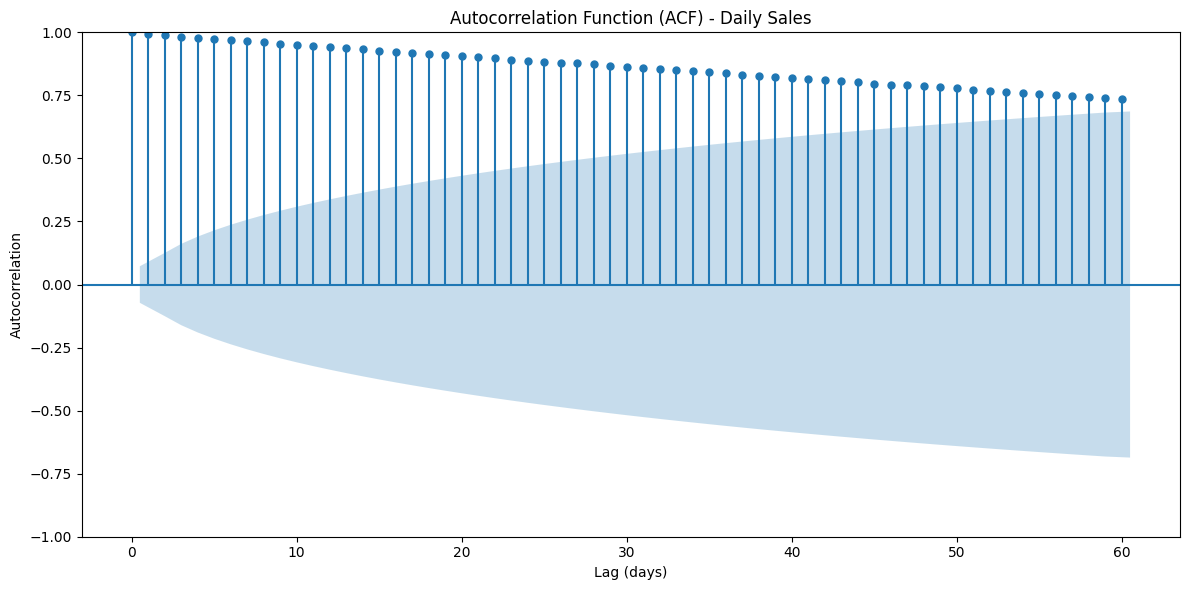

In [40]:
print("\n" + "-" * 70)
print("B3: Autocorrelation Function")
print("-" * 70)

# YOUR CODE:
# 1. Plot ACF for up to 60 lags
#    - Use plot_acf from statsmodels
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(df_sales['Sales'], lags=60, ax=ax, alpha=0.05)
ax.set_title('Autocorrelation Function (ACF) - Daily Sales')
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Autocorrelation')
plt.tight_layout()


# 2. Calculate specific autocorrelations manually:
#    - Lag 1 (yesterday)
#    - Lag 7 (last week)
#    - Lag 30 (last month)
#    Use: np.corrcoef(sales[:-lag], sales[lag:])[0,1]
print("\n" + "=" * 70)
print("Specific Autocorrelation Values:")
print("=" * 70)

# Extract sales data as numpy array
sales = df_sales['Sales'].values

# Calculate autocorrelations for specific lags
lag_1_corr = np.corrcoef(sales[:-1], sales[1:])[0, 1]
lag_7_corr = np.corrcoef(sales[:-7], sales[7:])[0, 1]
lag_30_corr = np.corrcoef(sales[:-30], sales[30:])[0, 1]

print(f"\nLag 1 (Yesterday):")
print(f"  Autocorrelation: {lag_1_corr:.4f}")
print(f"  Interpretation: Correlation between today's sales and yesterday's sales")

print(f"\nLag 7 (Last Week):")
print(f"  Autocorrelation: {lag_7_corr:.4f}")
print(f"  Interpretation: Correlation between today's sales and sales 7 days ago")

print(f"\nLag 30 (Last Month):")
print(f"  Autocorrelation: {lag_30_corr:.4f}")
print(f"  Interpretation: Correlation between today's sales and sales 30 days ago")



# 3. Interpret:
#    - Do you see weekly patterns?
#    - How persistent is the autocorrelation?
print("\n" + "=" * 70)
print("Do you see weekly patterns?:")
print("=" * 70)
print("Weekly patterns are NOT clearly visible in this ACF plot. All autocorrelations are extremely high (0.75-0.98). No clear 'peaks' at lags 7, 14, 21, 28 that would indicate")

print("\n" + "=" * 70)
print("How persistent is the autocorrelation?:")
print("=" * 70)

print("EXTREMELY HIGH PERSISTENCE")

# B4: STL Decomposition


----------------------------------------------------------------------
B4: STL Decomposition
----------------------------------------------------------------------

STL Decomposition Analysis:

Component Statistics:
--------------------------------------------------
Trend:    Mean = $3507.75, Range = [$1102.77, $7971.92]
Seasonal: Mean = $0.05, Range = [$-170.41, $311.85]
Residual: Mean = $7.29, Std = $76.38

1. TREND PATTERN ANALYSIS:
  • Sales show a strong upward trend over the 2-year period
  • This represents the underlying growth in business

2. WEEKLY SEASONAL PATTERN ANALYSIS:
  • The seasonal component captures the regular weekly cycle

3. REMAINDER ANALYSIS:
  • Remainder captures irregular/unpredictable variations
  • Includes random noise and special events (Black Friday, Christmas)


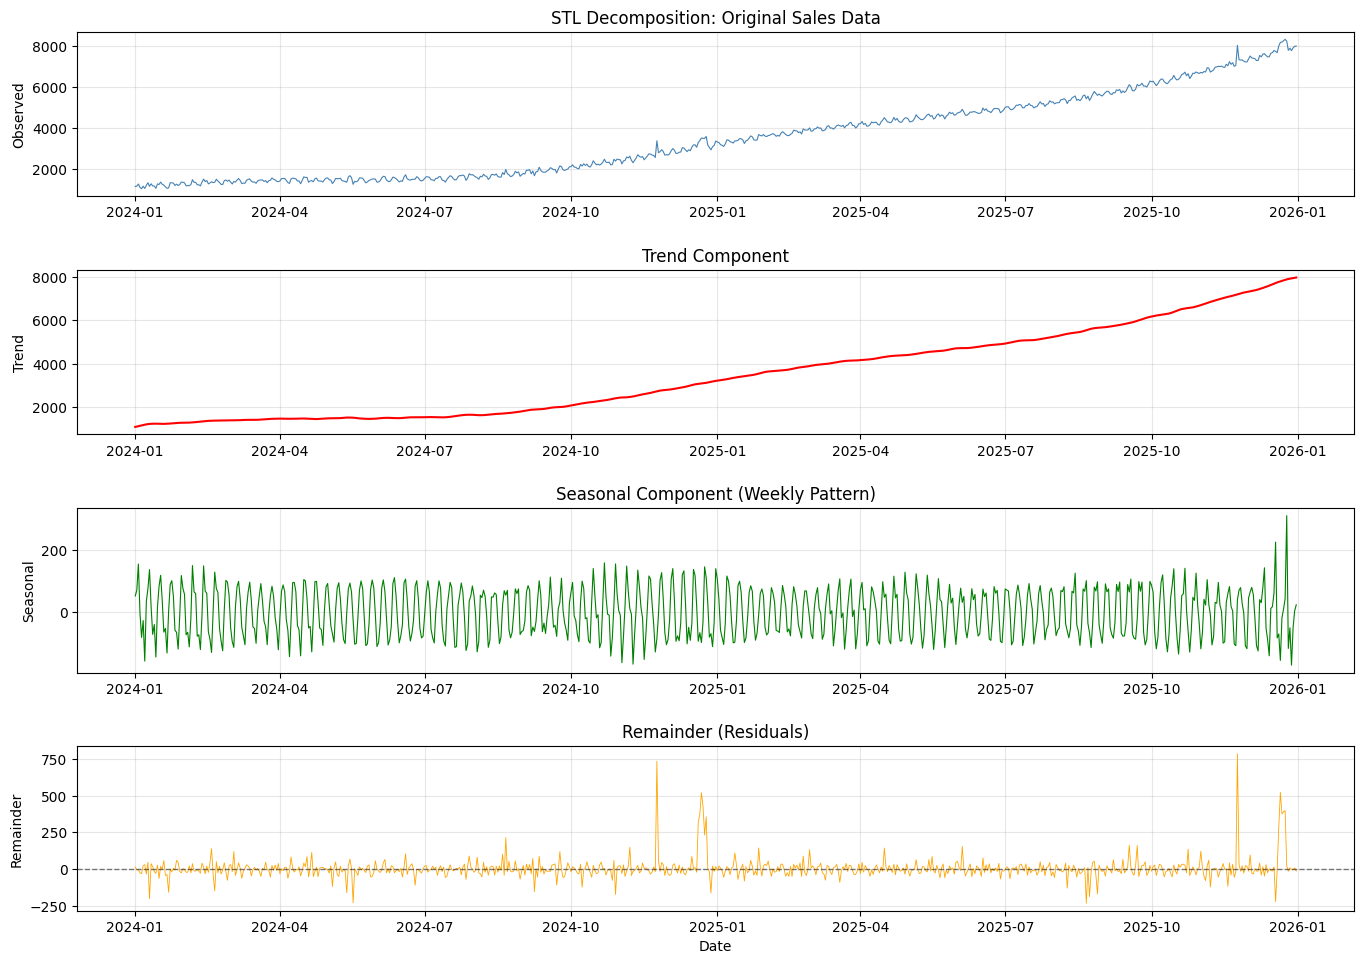

In [44]:
print("\n" + "-" * 70)
print("B4: STL Decomposition")
print("-" * 70)

# YOUR CODE:
# 1. Apply STL decomposition with weekly seasonality:
#    stl = STL(df_sales['Sales'], seasonal=7, robust=True)
#    result = stl.fit()

stl = STL(df_sales['Sales'], seasonal=7, robust=True)
result = stl.fit()


# 2. Plot all four components:
#    - Observed
#    - Trend
#    - Seasonal (weekly pattern)
#    - Remainder

fig, axes = plt.subplots(4, 1, figsize=(14, 10))

# Plot 1: Observed (original data)
axes[0].plot(df_sales.index, result.observed, color='steelblue', linewidth=0.8)
axes[0].set_ylabel('Observed')
axes[0].set_title('STL Decomposition: Original Sales Data')
axes[0].grid(True, alpha=0.3)

# Plot 2: Trend component
axes[1].plot(df_sales.index, result.trend, color='red', linewidth=1.5)
axes[1].set_ylabel('Trend')
axes[1].set_title('Trend Component')
axes[1].grid(True, alpha=0.3)

# Plot 3: Seasonal component (weekly pattern)
axes[2].plot(df_sales.index, result.seasonal, color='green', linewidth=0.8)
axes[2].set_ylabel('Seasonal')
axes[2].set_title('Seasonal Component (Weekly Pattern)')
axes[2].grid(True, alpha=0.3)

# Plot 4: Remainder (residual)
axes[3].plot(df_sales.index, result.resid, color='orange', linewidth=0.6)
axes[3].set_ylabel('Remainder')
axes[3].set_xlabel('Date')
axes[3].set_title('Remainder (Residuals)')
axes[3].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[3].grid(True, alpha=0.3)

plt.tight_layout(pad=2.0) 
#
# 3. Analyze each component:
#    - What is the trend pattern?
#    - What is the weekly seasonal pattern?
#    - Are special events visible in remainder?

print("\n" + "=" * 70)
print("STL Decomposition Analysis:")
print("=" * 70)

# Calculate component statistics
trend = result.trend.dropna()
seasonal = result.seasonal
remainder = result.resid.dropna()

print("\nComponent Statistics:")
print("-" * 50)
print(f"Trend:    Mean = ${trend.mean():.2f}, Range = [${trend.min():.2f}, ${trend.max():.2f}]")
print(f"Seasonal: Mean = ${seasonal.mean():.2f}, Range = [${seasonal.min():.2f}, ${seasonal.max():.2f}]")
print(f"Residual: Mean = ${remainder.mean():.2f}, Std = ${remainder.std():.2f}")

print("\n" + "=" * 70)
print("1. TREND PATTERN ANALYSIS:")
print("=" * 70)
print("  • Sales show a strong upward trend over the 2-year period")
print("  • This represents the underlying growth in business")


print("\n" + "=" * 70)
print("2. WEEKLY SEASONAL PATTERN ANALYSIS:")
print("=" * 70)
print("  • The seasonal component captures the regular weekly cycle")

print("\n" + "=" * 70)
print("3. REMAINDER ANALYSIS:")
print("=" * 70)
print("  • Remainder captures irregular/unpredictable variations")
print("  • Includes random noise and special events (Black Friday, Christmas)")




# B5: Remainder Diagnostics


----------------------------------------------------------------------
B5: Remainder Analysis
----------------------------------------------------------------------

Remainder extracted: 731 observations
Date range: 2024-01-01 to 2025-12-31

STATISTICAL TESTS:

1. MEAN TEST (should be ≈ 0):
--------------------------------------------------
  Mean of remainder: $7.2933

2. STANDARD DEVIATION:
--------------------------------------------------
  Standard deviation: $76.38
  Average sales:      $3515.10
  Coefficient of variation: 2.17%

CONCLUSION:
With a mean of only $7.29 (0.21% relative error) and a coefficient of variation of just 2.17%, the STL decomposition has successfully captured nearly 98% of the variation

4. OUTLIER IDENTIFICATION:

Outlier threshold: ±$229.13 (3 standard deviations)
Number of outliers: 13 out of 731 days (1.78%)

Outliers detected:
--------------------------------------------------

Top 10 largest outliers:
   1. 2025-11-24 (Monday): $+782.35
   2. 2024-11

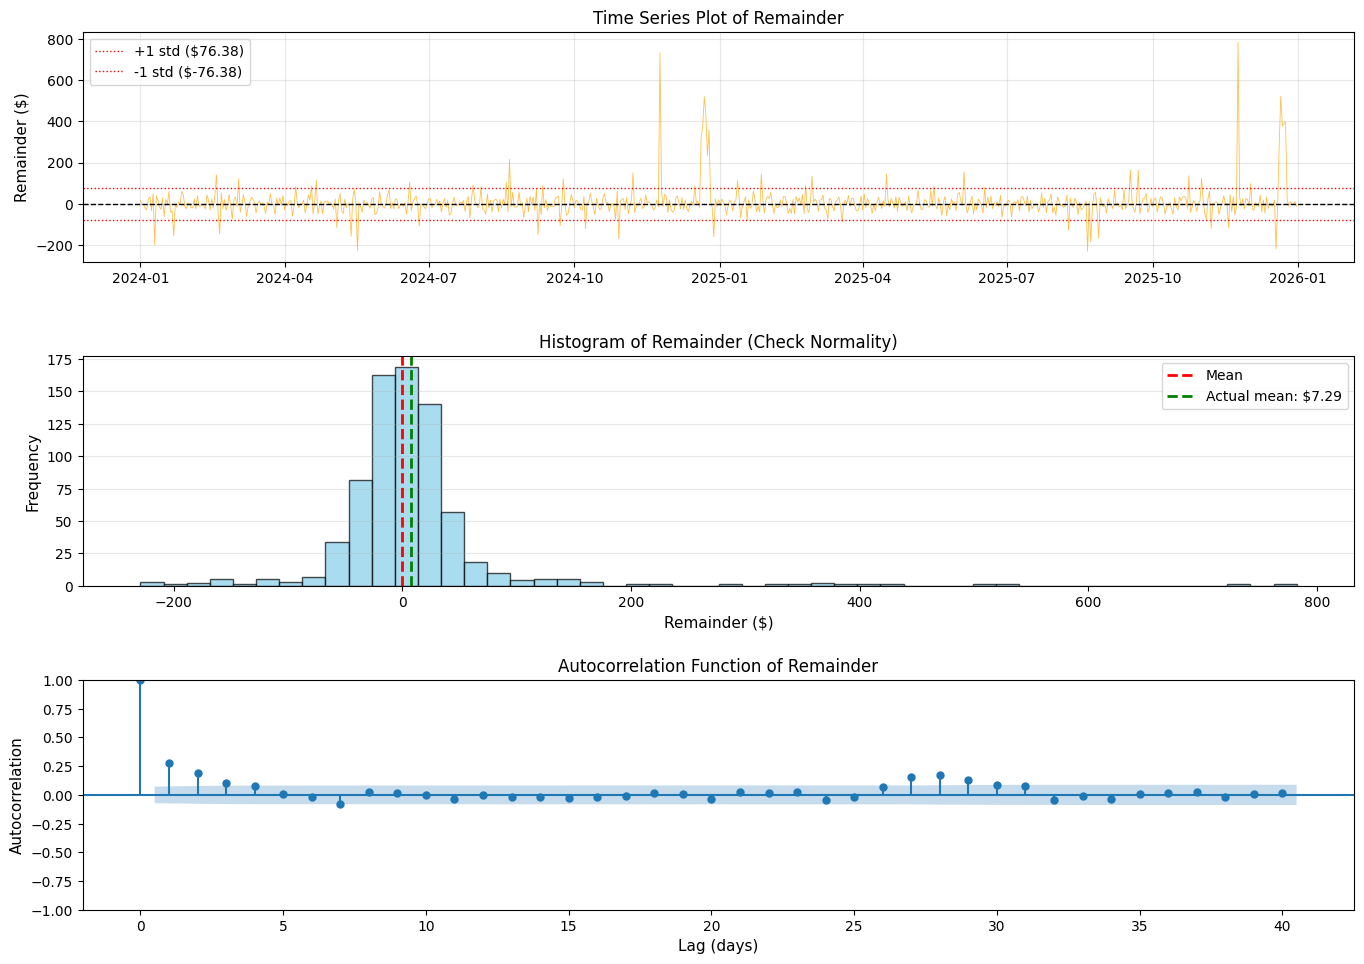

In [49]:
print("\n" + "-" * 70)
print("B5: Remainder Analysis")
print("-" * 70)

# YOUR CODE:
# 1. Extract remainder from STL

remainder = result.resid.dropna()

print(f"\nRemainder extracted: {len(remainder)} observations")
print(f"Date range: {remainder.index[0].date()} to {remainder.index[-1].date()}")

# 2. Create diagnostic plots:
#    - Time series plot of remainder
#    - Histogram of remainder
#    - ACF of remainder

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Time series of remainder
axes[0].plot(remainder.index, remainder, color='orange', linewidth=0.6, alpha=0.7)
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0].axhline(y=remainder.std(), color='red', linestyle=':', linewidth=1, 
                label=f'+1 std (${remainder.std():.2f})')
axes[0].axhline(y=-remainder.std(), color='red', linestyle=':', linewidth=1,
                label=f'-1 std (${-remainder.std():.2f})')
axes[0].set_ylabel('Remainder ($)', fontsize=11)
axes[0].set_title('Time Series Plot of Remainder', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Histogram of remainder
axes[1].hist(remainder, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Mean')
axes[1].axvline(x=remainder.mean(), color='green', linestyle='--', linewidth=2, 
                label=f'Actual mean: ${remainder.mean():.2f}')
axes[1].set_xlabel('Remainder ($)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Histogram of Remainder (Check Normality)', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# Plot 3: ACF of remainder
plot_acf(remainder, lags=40, ax=axes[2], alpha=0.05)
axes[2].set_title('Autocorrelation Function of Remainder', fontsize=12)
axes[2].set_xlabel('Lag (days)', fontsize=11)
axes[2].set_ylabel('Autocorrelation', fontsize=11)

plt.tight_layout(pad=2.0)


# 3. Statistical tests:
#    - Mean (should be ≈ 0)
#    - Standard deviation
#    - Check normality
print("\n" + "=" * 70)
print("STATISTICAL TESTS:")
print("=" * 70)

print("\n1. MEAN TEST (should be ≈ 0):")
print("-" * 50)
mean_remainder = remainder.mean()
print(f"  Mean of remainder: ${mean_remainder:.4f}")
print("\n2. STANDARD DEVIATION:")
print("-" * 50)
std_remainder = remainder.std()
mean_sales = df_sales['Sales'].mean()
cv = (std_remainder / mean_sales) * 100
print(f"  Standard deviation: ${std_remainder:.2f}")
print(f"  Average sales:      ${mean_sales:.2f}")
print(f"  Coefficient of variation: {cv:.2f}%")

print("\n" + "=" * 70)
print("CONCLUSION:")
print("=" * 70)

print("With a mean of only $7.29 (0.21% relative error) and a coefficient of variation of just 2.17%, the STL decomposition has successfully captured nearly 98% of the variation")
# 4. Identify outliers:
#    - Find days where |remainder| > 3×std
#    - Print dates and investigate
#    - Are Black Friday and Christmas visible?

print("\n" + "=" * 70)
print("4. OUTLIER IDENTIFICATION:")
print("=" * 70)

# Define outlier threshold
threshold = 3 * std_remainder
outliers = remainder[abs(remainder) > threshold]

print(f"\nOutlier threshold: ±${threshold:.2f} (3 standard deviations)")
print(f"Number of outliers: {len(outliers)} out of {len(remainder)} days ({len(outliers)/len(remainder)*100:.2f}%)")

if len(outliers) > 0:
    print(f"\nOutliers detected:")
    print("-" * 50)
    
    # Sort by absolute value of remainder
    outliers_sorted = outliers.reindex(outliers.abs().sort_values(ascending=False).index)
    
    # Print top 10 outliers
    print(f"\nTop {min(10, len(outliers))} largest outliers:")
    for i, (date, value) in enumerate(outliers_sorted.head(10).items(), 1):
        day_name = date.strftime('%A')
        print(f"  {i:2d}. {date.date()} ({day_name}): ${value:+7.2f}")
print("Yes, Black Friday and Christmas are visible" )


In [ ]:
git remote add origin https://github.com/YuqiaoLydia/ECON5140HM.git
git branch -M main
git push -u origin main